In [1]:
%matplotlib inline

from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists
from datetime import datetime
from tensorflow.keras.metrics import top_k_categorical_accuracy, CategoricalHinge, Recall, Precision
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

import tensorflow as tf
import tensorflow.keras.backend as K
# from tensorflow.keras import metrics

import tensorflow.keras
from tensorflow.compat.v2.keras.layers import Input

import matplotlib.pyplot as plt
import seaborn as sns

import random, os, sys
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.python.keras.layers import Layer
tf.compat.v1.disable_eager_execution
pd.set_option('precision', 30)
np.set_printoptions(precision = 30)


#np.random.seed(368)
#tf.random.set_seed(368)

In [2]:
xfile='C:\\workspace\\j6stock\\xau_usd_OHLC2.0Tp1.0Cl100Vp.txt'

seq_len = 60*6 #60*10 # 3 days + 2 features is enough memory
batch_size = int(2048/3)       # Batch size
# mini_batch_size = 64       # Batch size

learning_rate = 0.001  #0.0001  # Learning rate (default is 0.001)
epochs = 500


y_column = 6
compute_val_at = 0
acc_filtered_r = 0.8


upperTailFilter = 0.4
lowerTailFilter = 0.4

import tensorflow as tf
from tensorflow.python import debug as tf_debug
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
#from keras.models import Sequential
#from keras.layers.core import Dense, Dropout, Activation
#from keras.layers.recurrent import LSTM
#from keras.models import load_model
#import keras
import pandas as pd ## can be remove once pandas_datareader 0.7 using
pd.core.common.is_list_like = pd.api.types.is_list_like ## can be remove once pandas_datareader 0.7 using
import pandas_datareader.data as web
import h5py
import os



def get_stock_data(normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    global upperTailFilter, lowerTailFilter
    
    df = pd.read_csv(filepath_or_buffer  = xfile )
    #TODO Use previous close instead of open
    df['change'] = df['close'] - df['open']
    df['tail_upper'] = df['high'].copy()
    df['tail_lower'] = df['low'].copy()
    for i, row in df.iterrows():
        df.at[i, 'tail_upper'] = df.at[i, 'high'] - (df.at[i, 'open'] if df.at[i, 'open'] > df.at[i, 'close'] else df.at[i, 'close'])
        df.at[i, 'tail_lower'] = (df.at[i, 'close'] if df.at[i, 'close'] < df.at[i, 'open'] else df.at[i, 'open']) - df.at[i, 'low']
    
    df.dropna(inplace=True)
    df.drop('open', axis=1, inplace=True)
    df.drop('high', axis=1, inplace=True)
    df.drop('low', axis=1, inplace=True)
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean() 
    df.dropna(inplace=True)
    
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        #df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        #df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        #df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        #df['vol'] = min_max_scaler.fit_transform(df.vol.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
#         df['change'] = min_max_scaler.fit_transform(df['change'].values.reshape(-1,1)) # no rescale for keep the negative value
        df['tail_upper'] = min_max_scaler.fit_transform(df['tail_upper'].values.reshape(-1,1))
        upperTailFilter = min_max_scaler.transform([[upperTailFilter]])[0][0] 
        df['tail_lower'] = min_max_scaler.fit_transform(df['tail_lower'].values.reshape(-1,1))
        lowerTailFilter = min_max_scaler.transform([[lowerTailFilter]])[0][0] 
        
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))   
                #pd.concat([min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1)), df], axis=1)
                ma_data = df['{}ma'.format(moving)]
                df.drop(labels=['{}ma'.format(moving)], axis=1, inplace=True)
                df = pd.concat([ma_data, df], axis=1)
    df.dropna(inplace=True)

    
    # Move y_result to the rightmost for the ease of training
    adj_close = df['y_result']
    df.drop(labels=['y_result'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)

    return df

#df = get_stock_data( ma=[50, 100, 200])
df = get_stock_data(ma=[240])

# amount_of_features = len(df.columns)-1+(input2Length*-1)

# def load_data(stock, seq_len):
#     print ("Amount of features = {}".format(amount_of_features))
#     data = stock.as_matrix()
#     sequence_length = seq_len + 1 # index starting from 0
#     x_result = []
#     x_result2 = []
#     y_result = []
#     for index in range(seq_len, len(data) ): # maxmimum date = lastest date - sequence length
#         x_result.append(data[index-seq_len: index,
#                              :-1 + (input2Length*-1) # -2 is ignore Input2 features
#                             ]) # index : index + 22days
#         x_result2.append(data[index, -1 + (input2Length*-1):-1])
#         y_result.append(data[index ,-1]);

#     x_result, x_result2, y_result = shuffle(x_result, x_result2, y_result , random_state=2)

#     #print('---', data[0])
#     #print('---', x_result[0])
#     #print('---', y_result[0])
#     x_result = np.array(x_result)
#     x_result2 = np.array(x_result2)
#     y_result = np.array(y_result)
#     print ("Amount of data = {}".format(y_result.shape[0]))

#     percentageSplit = 0.5 # 60% split
#     row = round(percentageSplit * y_result.shape[0]) 
#     print ("Split = {}".format(row))
 
#     X_train = x_result[:int(row), :] 
#     X_train2 = x_result2[:int(row), :] 
#     y_train = y_result[:int(row)] 
#     print ("Amount of training data = {}".format(y_train.shape[0]))
#     X_test = x_result[int(row):, :]
#     X_test2 = x_result2[int(row):, :]
#     y_test = y_result[int(row):]
#     # filter for 1 and -1 for validation only
#     X_test = X_test[y_test[:]!=0,:]
#     X_test2 = X_test2[y_test[:]!=0,:]
#     y_test = y_test[y_test[:]!=0]
    
#     # split 50% again for test and validation set
#     row = round(percentageSplit * y_test.shape[0]) 
#     X_val = X_test[int(row):, :]
#     X_val2 = X_test2[int(row):, :]
#     y_val = y_test[int(row):]
#     print ("Amount of validation data = {}".format(y_val.shape[0]))
#     X_test = X_test[:int(row), :]
#     X_test2 = X_test2[:int(row), :]
#     y_test = y_test[:int(row)]
#     print ("Amount of testing data = {}".format(y_test.shape[0]))
#     #print(result.shape[0], len(y_result), int(row), y_result[int(row):])
#     #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features-1))
#     #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features-1))    
#     return [X_train, X_train2, y_train, X_test, X_test2, y_test, X_val, X_val2, y_val]



classes = [1, 0, -1]
lb = preprocessing.LabelBinarizer()
lb.fit(classes)
lb.transform([-1, 0, 1])

df_to_dataset = df[['close', 'change', '240ma'
                   ]].copy()
df_to_dataset_input2 = df[[ 'tail_upper', 'tail_lower', 'change' ,'cross_360p_high', 'cross_1440p_high'
                          ]].copy()

amount_of_features = len(df_to_dataset.columns)
input2Length = len(df_to_dataset_input2.columns)

df.drop(labels=['close'], axis=1, inplace=True)
df.drop(labels=['change'], axis=1, inplace=True)
df.drop(labels=['tail_upper'], axis=1, inplace=True)
df.drop(labels=['tail_lower'], axis=1, inplace=True)
df.drop(labels=['cross_360p_high'], axis=1, inplace=True)
df.drop(labels=['cross_1440p_high'], axis=1, inplace=True)

df_to_dataset_y = lb.transform(df[['y_result']].copy())
df.drop(labels=['y_result'], axis=1, inplace=True)

train_data_no = int(len(df_to_dataset_y)/2)
test_data_no = int(train_data_no/2)
v_data_no = test_data_no

train_x_1 = df_to_dataset.iloc[:train_data_no].values
train_x_2 = df_to_dataset_input2.iloc[:train_data_no].values
train_y = df_to_dataset_y[:train_data_no]                                                   

test_x_1 = df_to_dataset.iloc[train_data_no:train_data_no+test_data_no].values
test_x_2 = df_to_dataset_input2.iloc[train_data_no:train_data_no+test_data_no].values
test_y = df_to_dataset_y[train_data_no:train_data_no+test_data_no]                                                   

v_x_1 = df_to_dataset.iloc[train_data_no+test_data_no:].values
v_x_2 = df_to_dataset_input2.iloc[train_data_no+test_data_no:].values
v_y = df_to_dataset_y[train_data_no+test_data_no:]                                                   


def make_window_dataset(ds, window_size=seq_len, shift=1, stride=1):
  windows = ds.window(window_size, shift=shift, stride=stride)

  def batch(sub):
    ret = ()
    for index in range(2):
      ret = ret + ( sub[index].batch(window_size, drop_remainder=True), )
    return ret
  def sub_to_batch(sub, sub2): 
    return tf.data.Dataset.zip((batch(sub), (sub2.batch(window_size, drop_remainder=True))))
  
  windows = windows.flat_map(sub_to_batch)
  windows = windows.map(lambda sub1, sub2: ((sub1[0], sub1[1][-1:][0]), (sub2[-1:][0] #, sub2[-1:][0]
                                                                        )))
  return windows

def filter_fn(a, b):
#   return a[1][0]>=upperTailFilter or a[1][1]>=lowerTailFilter or a[1][3]==1 or a[1][4]==1
  return a[1][4]==1

train_dataset_x = tf.data.Dataset.from_tensor_slices(((train_x_1, train_x_2),(train_y)))
train_dataset = make_window_dataset(train_dataset_x).filter(filter_fn).cache().batch(batch_size, drop_remainder=True) 

test_dataset_x = tf.data.Dataset.from_tensor_slices(((test_x_1, test_x_2),(test_y)))
test_dataset = make_window_dataset(test_dataset_x).filter(filter_fn).cache().batch(batch_size, drop_remainder=True)

v_dataset_x = tf.data.Dataset.from_tensor_slices(((v_x_1, v_x_2),(v_y)))
v_dataset = make_window_dataset(v_dataset_x).filter(filter_fn).cache().batch(batch_size, drop_remainder=True)


print('Total Size : {}'.format(train_dataset_x))
print('Total Filtered Size : {}'.format(v_dataset_x))


# X_tr, X_tr2, lab_tr, X_test, X_test2, lab_test, X_vld, X_vld2, lab_vld = load_data(df, seq_len)
# y_tr = lb.transform(lab_tr)
# y_vld = lb.transform(lab_vld)
# y_test = lb.transform(lab_test)


# train_X = X_tr
# train_X2 = X_tr2
# train_y = y_tr
# valid_X = X_vld
# valid_X2 = X_vld2
# valid_y = y_vld
# test_X = X_test
# test_X2 = X_test2
# test_y = y_test

# print(train_X.shape)
# print(train_y[0])
# print(train_y[1])
# print(train_y[2])

Total Size : <TensorSliceDataset shapes: (((3,), (5,)), (3,)), types: ((tf.float64, tf.float64), tf.int32)>
Total Filtered Size : <TensorSliceDataset shapes: (((3,), (5,)), (3,)), types: ((tf.float64, tf.float64), tf.int32)>


In [77]:
# https://www.kaggle.com/shujian/transformer-with-lstm

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='tanh')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask



In [90]:
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
def CnnTransformerModel():
#    i = tf.compat.v2.keras.layers.Flatten(input_shape=(batch_size, amount_of_features))
    i = tf.compat.v2.keras.layers.Input(shape = (seq_len, amount_of_features)#, batch_size=mini_batch_size
                                       )
    
    x = tf.compat.v2.keras.layers.Convolution1D(64*2, kernel_size = 4, strides=2)(i)
    x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
    x = tf.compat.v2.keras.layers.Convolution1D(64, kernel_size = 2, dilation_rate=2)(x)
    x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
    x = tf.compat.v2.keras.layers.Convolution1D(32, kernel_size = 2, dilation_rate=2)(x)
    x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.compat.v2.keras.layers.Convolution1D(32, kernel_size = 2, dilation_rate=2)(x)
    x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
#     x = tf.compat.v2.keras.layers.Convolution1D(32, kernel_size = 4, strides = 2)(x)
#     x = tf.compat.v2.keras.layers.BatchNormalization()(x)
#     x = tf.compat.v2.keras.layers.Activation('relu')(x)
#     x = tf.keras.layers.Dropout(rate=0.2)(x)
#     x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
#     x = tf.compat.v2.keras.layers.Convolution1D(32, kernel_size = 4, dilation_rate=5)(x)
#     x = tf.compat.v2.keras.layers.BatchNormalization()(x)
#     x = tf.compat.v2.keras.layers.Activation('relu')(x)
    x = (CuDNNLSTM(16, return_sequences = True, return_state = False))(x)
#     x, slf_attn = MultiHeadAttention(n_head=int(80), d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    concat2 = concatenate([avg_pool, max_pool])
    x = Dense(600)(concat2)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    x = Dropout(0.2)(x)
    
    x = Dense(300)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    x = Dropout(0.2)(x)
    
    x = Dense(150)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)    
    x = Dropout(0.2)(x)
    
    x = Dense(70)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)    
    x = Dropout(0.2)(x)
    
    x = Dense(35, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)    
    
    x = Dense(15)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)    
    
    x = Dense(7)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    
    tailInput = Input(shape=(input2Length,))
    tailLayers = Dense(input2Length, activation='tanh')(tailInput)
    tailLayers = Dense(input2Length*2, activation='tanh')(tailInput)
    tailLayers = Dense(input2Length*2*2, activation='tanh')(tailInput)
    tailLayers = BatchNormalization()(tailInput)
    tailLayers = Dropout(0.2)(tailInput)
    tailLayers = Dense(input2Length*2, activation='tanh')(tailInput)
    tailLayers = Dense(3, activation='tanh')(tailInput)
    
#     concat = concatenate([avg_pool, max_pool, tailLayers])
    concat = concatenate([x, tailLayers])

    y = Dense(3,activation = 'softmax')(concat)
    

    return Model(inputs = [i, tailInput], outputs = [y])

In [91]:

model = CnnTransformerModel()
optimizer = tf.keras.optimizers.Adam(lr=0.090, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, 
                          loss='categorical_crossentropy'
#                           loss_weights=[1., 1.]
#                           loss_weights=[1.]
#                             , metrics=['accuracy']
                           , metrics=['accuracy', Recall(thresholds=0.1, class_id=0, top_k=1)
                                , Recall(thresholds=0.1, class_id=2, top_k=1)
                                  , Precision(thresholds=0.1, class_id=0, top_k=1)
                                 , Precision(thresholds=0.1, class_id=2, top_k=1)
                                 ]
             )
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 360, 3)]     0                                            
__________________________________________________________________________________________________
conv1d_70 (Conv1D)              (None, 179, 128)     1664        input_35[0][0]                   
__________________________________________________________________________________________________
batch_normalization_197 (BatchN (None, 179, 128)     512         conv1d_70[0][0]                  
__________________________________________________________________________________________________
activation_192 (Activation)     (None, 179, 128)     0           batch_normalization_197[0][0]    
___________________________________________________________________________________________

**Visualizing The Model Architecture**

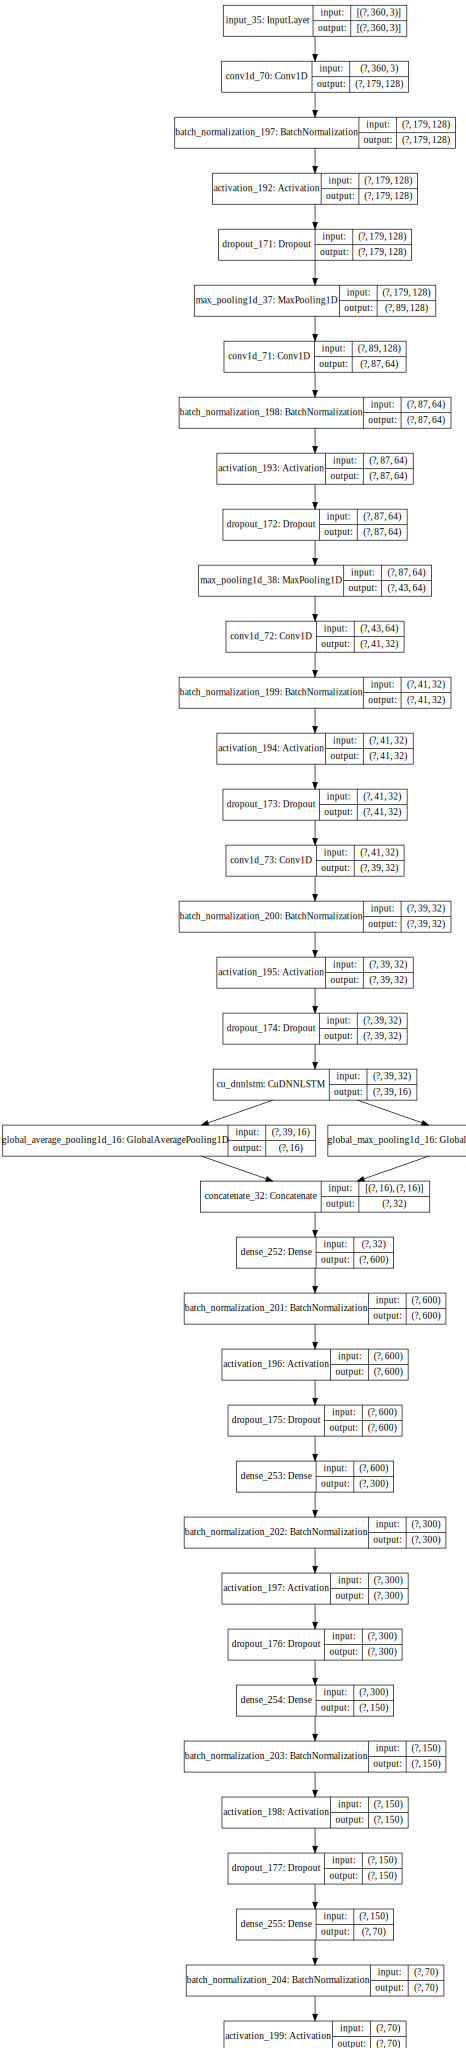

In [92]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))

Train the model with early stopping

In [93]:
from datetime import datetime
logdir = "logs\\scalars\\" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
weight_path="{}_weights.best.hdf5".format('stroke_lstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=100) 
callbacks_list = [checkpoint
                  , early
                  , reduceLROnPlat
                  , tensorboard_callback
                 ]


from IPython.display import clear_output
model.fit(train_dataset,
                      validation_data = v_dataset, 
#                       batch_size = 10,
                      epochs = 1000,
                      use_multiprocessing = True,
                      callbacks = callbacks_list)

# model.fit([train_X, train_X2], [train_y, train_y],
#                       validation_data = ([valid_X, valid_X2], [valid_y, valid_y]), 
#                       batch_size = batch_size,
#                       epochs = 500,
#                       callbacks = callbacks_list)

#clear_output()

W0607 23:49:21.092264 12736 callbacks.py:2207] `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


Epoch 1/1000
      2/Unknown - 0s 0s/step - loss: 1.2070 - accuracy: 0.2977 - recall_26: 0.4839 - recall_27: 0.0859 - precision_26: 0.1705 - precision_27: 0.22 - 4s 2s/step - loss: 1.1524 - accuracy: 0.3358 - recall_26: 0.2167 - recall_27: 0.2331 - precision_26: 0.1711 - precision_27: 0.2134

W0607 23:49:37.863744 12736 callbacks.py:307] Method (on_train_batch_end) is slow compared to the batch update (2.033191). Check your callbacks.


     19/Unknown - 4s 1s/step - loss: 1.0766 - accuracy: 0.4483 - recall_26: 0.1285 - recall_27: 0.1990 - precision_26: 0.1847 - precision_27: 0.21 - 4s 701ms/step - loss: 1.0206 - accuracy: 0.5112 - recall_26: 0.0893 - recall_27: 0.1447 - precision_26: 0.1847 - precision_27: 0.218 - 4s 533ms/step - loss: 1.0132 - accuracy: 0.5390 - recall_26: 0.0721 - recall_27: 0.1057 - precision_26: 0.1847 - precision_27: 0.218 - 4s 433ms/step - loss: 1.0155 - accuracy: 0.5425 - recall_26: 0.0562 - recall_27: 0.0836 - precision_26: 0.1847 - precision_27: 0.218 - 4s 339ms/step - loss: 0.9822 - accuracy: 0.5771 - recall_26: 0.0614 - recall_27: 0.0695 - precision_26: 0.1701 - precision_27: 0.218 - 4s 297ms/step - loss: 1.0124 - accuracy: 0.5572 - recall_26: 0.0519 - recall_27: 0.0543 - precision_26: 0.1701 - precision_27: 0.218 - 5s 265ms/step - loss: 1.0166 - accuracy: 0.5564 - recall_26: 0.0442 - recall_27: 0.0482 - precision_26: 0.1701 - precision_27: 0.218 - 5s 240ms/step - loss: 1.0147 - accuracy: 

Epoch 6/1000
17/19 [=========================>....] - ETA: 0s - loss: 1.0240 - accuracy: 0.5293 - recall_26: 0.0242 - recall_27: 0.0000e+00 - precision_26: 0.4286 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0174 - accuracy: 0.5274 - recall_26: 0.0116 - recall_27: 0.0000e+00 - precision_26: 0.2000 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9869 - accuracy: 0.5683 - recall_26: 0.0111 - recall_27: 0.0000e+00 - precision_26: 0.2500 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9611 - accuracy: 0.5937 - recall_26: 0.0075 - recall_27: 0.0000e+00 - precision_26: 0.2500 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9752 - accuracy: 0.5862 - recall_26: 0.0058 - recall_27: 0.0000e+00 - precision_26: 0.2500 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9447 - accuracy: 0.6069 - recall_26: 0.0052 - recall_27: 0.0000e+00 - precision_26: 0.2500 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9625 - accuracy: 0.5954 - recall_26: 0.0042 - recall_27: 0.0000e+00 - precision_26: 0.2500 - precision_27: 0.000

19/19 [==============================] - ETA: 0s - loss: 1.0221 - accuracy: 0.5279 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0008 - accuracy: 0.5554 - recall_26: 0.0518 - recall_27: 0.0000e+00 - precision_26: 0.3131 - precision_27: 0.0000e+00       - ETA: 0s - loss: 0.9764 - accuracy: 0.5816 - recall_26: 0.0383 - recall_27: 0.0000e+00 - precision_26: 0.3056 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9645 - accuracy: 0.5917 - recall_26: 0.0273 - recall_27: 0.0000e+00 - precision_26: 0.3056 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9627 - accuracy: 0.5941 - recall_26: 0.0225 - recall_27: 0.0000e+00 - precision_26: 0.3056 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9249 - accuracy: 0.6201 - recall_26: 0.0205 - recall_27: 0.0000e+00 - precision_26: 0.3056 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9603 - accuracy: 0.5944 - recall_26: 0.0173 - recall_27: 0.0000e+00 - precision_26: 0.3056 - precision_27: 0.

Epoch 21/1000
18/19 [===========================>..] - ETA: 0s - loss: 1.0265 - accuracy: 0.5279 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0184 - accuracy: 0.5279 - recall_26: 0.0023 - recall_27: 0.0000e+00 - precision_26: 0.0909 - precision_27: 0.0000e+00       - ETA: 0s - loss: 0.9943 - accuracy: 0.5683 - recall_26: 0.0014 - recall_27: 0.0000e+00 - precision_26: 0.0909 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9678 - accuracy: 0.5937 - recall_26: 9.3633e-04 - recall_27: 0.0000e+00 - precision_26: 0.0909 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9659 - accuracy: 0.5954 - recall_26: 6.8120e-04 - recall_27: 0.0000e+00 - precision_26: 0.0909 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9286 - accuracy: 0.6212 - recall_26: 6.1996e-04 - recall_27: 0.0000e+00 - precision_26: 0.0909 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9677 - accuracy: 0.5943 - recall_26: 4.8520e-04 - recall_27: 0.0000e+00 - precision

19/19 [==============================] - ETA: 0s - loss: 1.0196 - accuracy: 0.5279 - recall_26: 0.0081 - recall_27: 0.0000e+00 - precision_26: 0.1667 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0239 - accuracy: 0.5303 - recall_26: 0.0093 - recall_27: 0.0019 - precision_26: 0.1905 - precision_27: 0.5000       - ETA: 0s - loss: 1.0008 - accuracy: 0.5686 - recall_26: 0.0070 - recall_27: 0.0013 - precision_26: 0.1667 - precision_27: 0.25 - ETA: 0s - loss: 0.9742 - accuracy: 0.5905 - recall_26: 0.0052 - recall_27: 0.0010 - precision_26: 0.1667 - precision_27: 0.25 - ETA: 0s - loss: 0.9672 - accuracy: 0.5935 - recall_26: 0.0041 - recall_27: 7.7882e-04 - precision_26: 0.1667 - precision_27: 0.25 - ETA: 0s - loss: 0.9663 - accuracy: 0.5956 - recall_26: 0.0034 - recall_27: 6.3980e-04 - precision_26: 0.1667 - precision_27: 0.25 - ETA: 0s - loss: 0.9421 - accuracy: 0.6118 - recall_26: 0.0028 - recall_27: 5.1387e-04 - precision_26: 0.1667 - precision_27: 0.25 - ETA: 0s - loss: 0.9723 - accuracy: 

Epoch 41/1000
17/19 [=========================>....] - ETA: 0s - loss: 1.0271 - accuracy: 0.5279 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0158 - accuracy: 0.5298 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9888 - accuracy: 0.5695 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9728 - accuracy: 0.5944 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9772 - accuracy: 0.5868 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9330 - accuracy: 0.6217 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9674 - accuracy: 0.5958 - recall_26: 0.0000e+00 - recall_27: 0.

Epoch 46/1000
19/19 [==============================] - ETA: 0s - loss: 1.0219 - accuracy: 0.5279 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0168 - accuracy: 0.5298 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9770 - accuracy: 0.5695 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9578 - accuracy: 0.5911 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9523 - accuracy: 0.5940 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9353 - accuracy: 0.6074 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9498 - accuracy: 0.5958 - recall_26: 0.0000e+00 - recall_27: 0.

Epoch 51/1000
19/19 [==============================] - ETA: 0s - loss: 1.0184 - accuracy: 0.5279 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0155 - accuracy: 0.5298 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9767 - accuracy: 0.5695 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9523 - accuracy: 0.5944 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9587 - accuracy: 0.5868 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9182 - accuracy: 0.6217 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9499 - accuracy: 0.5958 - recall_26: 0.0000e+00 - recall_27: 0.

19/19 [==============================] - ETA: 0s - loss: 1.0204 - accuracy: 0.5279 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0128 - accuracy: 0.5298 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9735 - accuracy: 0.5695 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9537 - accuracy: 0.5911 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9569 - accuracy: 0.5868 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9353 - accuracy: 0.6074 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9294 - accuracy: 0.6121 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - pre

Epoch 64/1000
19/19 [==============================] - ETA: 0s - loss: 1.0168 - accuracy: 0.5279 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0122 - accuracy: 0.5298 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9738 - accuracy: 0.5695 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9532 - accuracy: 0.5911 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9565 - accuracy: 0.5868 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9347 - accuracy: 0.6074 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9287 - accuracy: 0.6121 - recall_26: 0.0000e+00 - recall_27: 0.

19/19 [==============================] - ETA: 0s - loss: 1.0199 - accuracy: 0.5279 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9814 - accuracy: 0.5594 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9579 - accuracy: 0.5855 - recall_26: 0.0035 - recall_27: 0.0000e+00 - precision_26: 0.4286 - precision_27: 0.0000e+00       - ETA: 0s - loss: 0.9501 - accuracy: 0.5948 - recall_26: 0.0037 - recall_27: 0.0000e+00 - precision_26: 0.4000 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9557 - accuracy: 0.5871 - recall_26: 0.0029 - recall_27: 0.0000e+00 - precision_26: 0.4000 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9340 - accuracy: 0.6076 - recall_26: 0.0026 - recall_27: 0.0000e+00 - precision_26: 0.4000 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9278 - accuracy: 0.6123 - recall_26: 0.0023 - recall_27: 0.0000e+00 - precision_26: 0.4000 - precisio

Epoch 78/1000
18/19 [===========================>..] - ETA: 0s - loss: 1.0186 - accuracy: 0.5279 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0088 - accuracy: 0.5298 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9565 - accuracy: 0.5850 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9481 - accuracy: 0.5944 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9457 - accuracy: 0.5960 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9154 - accuracy: 0.6217 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9462 - accuracy: 0.5947 - recall_26: 0.0000e+00 - recall_27: 0.

18/19 [===========================>..] - ETA: 0s - loss: 1.0207 - accuracy: 0.5279 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0056 - accuracy: 0.5303 - recall_26: 0.0023 - recall_27: 0.0000e+00 - precision_26: 0.5000 - precision_27: 0.0000e+00       - ETA: 0s - loss: 0.9667 - accuracy: 0.5698 - recall_26: 0.0014 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9497 - accuracy: 0.5915 - recall_26: 0.0041 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9521 - accuracy: 0.5867 - recall_26: 0.0066 - recall_27: 0.0000e+00 - precision_26: 0.2727 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9133 - accuracy: 0.6215 - recall_26: 0.0056 - recall_27: 0.0000e+00 - precision_26: 0.2500 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9438 - accuracy: 0.5956 - recall_26: 0.0047 - recall_27: 0.0000e+00 - precision_26: 0.2500 - precision_27: 0.

19/19 [==============================] - ETA: 0s - loss: 1.0149 - accuracy: 0.5279 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0064 - accuracy: 0.5298 - recall_26: 0.0023 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0000e+00       - ETA: 0s - loss: 0.9661 - accuracy: 0.5695 - recall_26: 0.0014 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9451 - accuracy: 0.5948 - recall_26: 0.0047 - recall_27: 0.0000e+00 - precision_26: 0.3571 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9513 - accuracy: 0.5868 - recall_26: 0.0066 - recall_27: 0.0000e+00 - precision_26: 0.3103 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9128 - accuracy: 0.6218 - recall_26: 0.0074 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9437 - accuracy: 0.5948 - recall_26: 0.0058 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.

Epoch 108/1000
18/19 [===========================>..] - ETA: 0s - loss: 1.0175 - accuracy: 0.5279 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0059 - accuracy: 0.5298 - recall_26: 0.0023 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0000e+00       - ETA: 0s - loss: 0.9651 - accuracy: 0.5692 - recall_26: 0.0014 - recall_27: 0.0000e+00 - precision_26: 0.2000 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9438 - accuracy: 0.5944 - recall_26: 0.0047 - recall_27: 0.0000e+00 - precision_26: 0.2941 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9500 - accuracy: 0.5868 - recall_26: 0.0088 - recall_27: 0.0000e+00 - precision_26: 0.3077 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9114 - accuracy: 0.6218 - recall_26: 0.0087 - recall_27: 0.0000e+00 - precision_26: 0.3182 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9421 - accuracy: 0.5948 - recall_26: 0.0068 - recall_27: 8.4674e-04 - precision_26: 0.3182 - p

19/19 [==============================] - ETA: 0s - loss: 1.0146 - accuracy: 0.5279 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0050 - accuracy: 0.5298 - recall_26: 0.0023 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0000e+00       - ETA: 0s - loss: 0.9648 - accuracy: 0.5695 - recall_26: 0.0014 - recall_27: 0.0000e+00 - precision_26: 0.2500 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9439 - accuracy: 0.5944 - recall_26: 0.0047 - recall_27: 0.0000e+00 - precision_26: 0.3125 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9496 - accuracy: 0.5867 - recall_26: 0.0073 - recall_27: 0.0000e+00 - precision_26: 0.2857 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9111 - accuracy: 0.6216 - recall_26: 0.0081 - recall_27: 0.0000e+00 - precision_26: 0.2955 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9408 - accuracy: 0.5957 - recall_26: 0.0068 - recall_27: 0.0000e+00 - precision_26: 0.2955 - precision_27: 0.

18/19 [===========================>..] - ETA: 0s - loss: 1.0125 - accuracy: 0.5279 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0048 - accuracy: 0.5298 - recall_26: 0.0023 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0000e+00       - ETA: 0s - loss: 0.9507 - accuracy: 0.5853 - recall_26: 0.0035 - recall_27: 0.0000e+00 - precision_26: 0.3750 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9422 - accuracy: 0.5935 - recall_26: 0.0050 - recall_27: 0.0000e+00 - precision_26: 0.2400 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9409 - accuracy: 0.5956 - recall_26: 0.0068 - recall_27: 0.0000e+00 - precision_26: 0.2941 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9107 - accuracy: 0.6214 - recall_26: 0.0068 - recall_27: 0.0000e+00 - precision_26: 0.2895 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9412 - accuracy: 0.5944 - recall_26: 0.0058 - recall_27: 0.0000e+00 - precision_26: 0.2791 - precision_27: 0.

17/19 [=========================>....] - ETA: 0s - loss: 1.0131 - accuracy: 0.5279 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0058 - accuracy: 0.5298 - recall_26: 0.0023 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0000e+00       - ETA: 0s - loss: 0.9652 - accuracy: 0.5695 - recall_26: 0.0014 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9433 - accuracy: 0.5946 - recall_26: 0.0047 - recall_27: 0.0000e+00 - precision_26: 0.3846 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9496 - accuracy: 0.5868 - recall_26: 0.0066 - recall_27: 0.0000e+00 - precision_26: 0.3462 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9110 - accuracy: 0.6218 - recall_26: 0.0068 - recall_27: 0.0000e+00 - precision_26: 0.3548 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9401 - accuracy: 0.5959 - recall_26: 0.0058 - recall_27: 0.0000e+00 - precision_26: 0.3548 - precision_27: 0.

19/19 [==============================] - ETA: 0s - loss: 1.0126 - accuracy: 0.5279 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9751 - accuracy: 0.5594 - recall_26: 0.0033 - recall_27: 0.0000e+00 - precision_26: 0.2857 - precision_27: 0.0000e+00       - ETA: 0s - loss: 0.9491 - accuracy: 0.5855 - recall_26: 0.0046 - recall_27: 0.0000e+00 - precision_26: 0.4000 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9413 - accuracy: 0.5935 - recall_26: 0.0050 - recall_27: 0.0000e+00 - precision_26: 0.2308 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9406 - accuracy: 0.5954 - recall_26: 0.0068 - recall_27: 0.0000e+00 - precision_26: 0.2778 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9106 - accuracy: 0.6212 - recall_26: 0.0068 - recall_27: 0.0000e+00 - precision_26: 0.2750 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9411 - accuracy: 0.5944 - recall_26: 0.0058 - recall_27: 0.0000e+00 - precision_26: 0.2727 - precision_27: 0.

19/19 [==============================] - ETA: 0s - loss: 1.0112 - accuracy: 0.5279 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0057 - accuracy: 0.5293 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9652 - accuracy: 0.5692 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9458 - accuracy: 0.5913 - recall_26: 0.0031 - recall_27: 0.0000e+00 - precision_26: 0.3750 - precision_27: 0.0000e+00       - ETA: 0s - loss: 0.9488 - accuracy: 0.5868 - recall_26: 0.0051 - recall_27: 0.0000e+00 - precision_26: 0.3182 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9278 - accuracy: 0.6074 - recall_26: 0.0052 - recall_27: 0.0000e+00 - precision_26: 0.3077 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9223 - accuracy: 0.6121 - recall_26: 0.0046 - recall_27: 0.0000e+00 - precision_26: 0.3077 - 

Epoch 163/1000
17/19 [=========================>....] - ETA: 0s - loss: 1.0140 - accuracy: 0.5293 - recall_26: 0.0081 - recall_27: 0.0000e+00 - precision_26: 0.5000 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0052 - accuracy: 0.5293 - recall_26: 0.0047 - recall_27: 0.0000e+00 - precision_26: 0.2222 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9646 - accuracy: 0.5701 - recall_26: 0.0070 - recall_27: 0.0000e+00 - precision_26: 0.3846 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9422 - accuracy: 0.5951 - recall_26: 0.0075 - recall_27: 0.0000e+00 - precision_26: 0.3636 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9486 - accuracy: 0.5875 - recall_26: 0.0102 - recall_27: 0.0000e+00 - precision_26: 0.3684 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9277 - accuracy: 0.6078 - recall_26: 0.0097 - recall_27: 0.0000e+00 - precision_26: 0.3409 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9393 - accuracy: 0.5960 - recall_26: 0.0079 - recall_27: 0.0000e+00 - precision_26: 0.3261 - precision_27: 0.0

19/19 [==============================] - ETA: 0s - loss: 1.0128 - accuracy: 0.5293 - recall_26: 0.0081 - recall_27: 0.0000e+00 - precision_26: 0.5000 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0052 - accuracy: 0.5298 - recall_26: 0.0023 - recall_27: 0.0000e+00 - precision_26: 0.2500 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9643 - accuracy: 0.5695 - recall_26: 0.0014 - recall_27: 0.0000e+00 - precision_26: 0.2000 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9446 - accuracy: 0.5913 - recall_26: 0.0031 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9407 - accuracy: 0.5938 - recall_26: 0.0041 - recall_27: 0.0000e+00 - precision_26: 0.2381 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9271 - accuracy: 0.6075 - recall_26: 0.0064 - recall_27: 0.0000e+00 - precision_26: 0.3226 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9217 - accuracy: 0.6122 - recall_26: 0.0057 - recall_27: 0.0000e+00 - precision_26: 0.3226 - precision_27: 0.0000e+ - ETA: 0s

18/19 [===========================>..] - ETA: 0s - loss: 1.0118 - accuracy: 0.5293 - recall_26: 0.0081 - recall_27: 0.0000e+00 - precision_26: 0.5000 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0046 - accuracy: 0.5293 - recall_26: 0.0047 - recall_27: 0.0000e+00 - precision_26: 0.2222 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9489 - accuracy: 0.5858 - recall_26: 0.0081 - recall_27: 0.0000e+00 - precision_26: 0.4118 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9408 - accuracy: 0.5937 - recall_26: 0.0075 - recall_27: 0.0000e+00 - precision_26: 0.2727 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9400 - accuracy: 0.5958 - recall_26: 0.0089 - recall_27: 0.0000e+00 - precision_26: 0.3095 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9097 - accuracy: 0.6216 - recall_26: 0.0087 - recall_27: 0.0000e+00 - precision_26: 0.3111 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9398 - accuracy: 0.5944 - recall_26: 0.0082 - recall_27: 0.0000e+00 - precision_26: 0.2931 - precision_27: 0.0000e+ - ETA: 0s

18/19 [===========================>..] - ETA: 0s - loss: 1.0096 - accuracy: 0.5308 - recall_26: 0.0161 - recall_27: 0.0000e+00 - precision_26: 0.6667 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0041 - accuracy: 0.5293 - recall_26: 0.0070 - recall_27: 0.0000e+00 - precision_26: 0.2727 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9476 - accuracy: 0.5853 - recall_26: 0.0081 - recall_27: 0.0000e+00 - precision_26: 0.3684 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9409 - accuracy: 0.5944 - recall_26: 0.0075 - recall_27: 0.0000e+00 - precision_26: 0.2963 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9394 - accuracy: 0.5958 - recall_26: 0.0102 - recall_27: 0.0000e+00 - precision_26: 0.3191 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9209 - accuracy: 0.6119 - recall_26: 0.0091 - recall_27: 0.0000e+00 - precision_26: 0.3077 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9390 - accuracy: 0.5948 - recall_26: 0.0107 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0000e+ - ETA: 0s

Epoch 198/1000
18/19 [===========================>..] - ETA: 0s - loss: 1.0117 - accuracy: 0.5308 - recall_26: 0.0161 - recall_27: 0.0000e+00 - precision_26: 0.6667 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0044 - accuracy: 0.5303 - recall_26: 0.0070 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9479 - accuracy: 0.5860 - recall_26: 0.0081 - recall_27: 0.0000e+00 - precision_26: 0.4375 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9409 - accuracy: 0.5951 - recall_26: 0.0075 - recall_27: 0.0000e+00 - precision_26: 0.3810 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9389 - accuracy: 0.5962 - recall_26: 0.0082 - recall_27: 0.0000e+00 - precision_26: 0.3429 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9089 - accuracy: 0.6222 - recall_26: 0.0093 - recall_27: 0.0000e+00 - precision_26: 0.3750 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9375 - accuracy: 0.5962 - recall_26: 0.0084 - recall_27: 0.0000e+00 - precision_26: 0.3721 - precision_27: 0.0

Epoch 203/1000
17/19 [=========================>....] - ETA: 0s - loss: 1.0089 - accuracy: 0.5293 - recall_26: 0.0081 - recall_27: 0.0000e+00 - precision_26: 0.5000 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0023 - accuracy: 0.5283 - recall_26: 0.0047 - recall_27: 0.0000e+00 - precision_26: 0.2000 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9617 - accuracy: 0.5686 - recall_26: 0.0056 - recall_27: 0.0000e+00 - precision_26: 0.2500 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9398 - accuracy: 0.5940 - recall_26: 0.0084 - recall_27: 0.0000e+00 - precision_26: 0.3000 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9463 - accuracy: 0.5868 - recall_26: 0.0109 - recall_27: 0.0000e+00 - precision_26: 0.3125 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9084 - accuracy: 0.6215 - recall_26: 0.0112 - recall_27: 0.0000e+00 - precision_26: 0.3051 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9372 - accuracy: 0.5958 - recall_26: 0.0115 - recall_27: 0.0000e+00 - precision_26: 0.3284 - precision_27: 0.0

Epoch 213/1000
18/19 [===========================>..] - ETA: 0s - loss: 1.0109 - accuracy: 0.5323 - recall_26: 0.0242 - recall_27: 0.0000e+00 - precision_26: 0.7500 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0030 - accuracy: 0.5298 - recall_26: 0.0093 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9468 - accuracy: 0.5855 - recall_26: 0.0093 - recall_27: 0.0000e+00 - precision_26: 0.3810 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9403 - accuracy: 0.5944 - recall_26: 0.0084 - recall_27: 0.0000e+00 - precision_26: 0.3103 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9391 - accuracy: 0.5962 - recall_26: 0.0123 - recall_27: 0.0000e+00 - precision_26: 0.3462 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9209 - accuracy: 0.6125 - recall_26: 0.0131 - recall_27: 0.0000e+00 - precision_26: 0.3710 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9388 - accuracy: 0.5955 - recall_26: 0.0155 - recall_27: 0.0000e+00 - precision_26: 0.3951 - precision_27: 0.0

18/19 [===========================>..] - ETA: 0s - loss: 1.0119 - accuracy: 0.5279 - recall_26: 0.0081 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0047 - accuracy: 0.5293 - recall_26: 0.0070 - recall_27: 0.0000e+00 - precision_26: 0.2727 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9624 - accuracy: 0.5695 - recall_26: 0.0084 - recall_27: 0.0000e+00 - precision_26: 0.3529 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9403 - accuracy: 0.5951 - recall_26: 0.0103 - recall_27: 0.0000e+00 - precision_26: 0.4074 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9384 - accuracy: 0.5965 - recall_26: 0.0116 - recall_27: 0.0000e+00 - precision_26: 0.3953 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9086 - accuracy: 0.6223 - recall_26: 0.0118 - recall_27: 0.0000e+00 - precision_26: 0.3800 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9382 - accuracy: 0.5952 - recall_26: 0.0121 - recall_27: 0.0000e+00 - precision_26: 0.3731 - precision_27: 0.0000e+ - ETA: 0s

Epoch 233/1000
17/19 [=========================>....] - ETA: 0s - loss: 1.0120 - accuracy: 0.5293 - recall_26: 0.0161 - recall_27: 0.0000e+00 - precision_26: 0.5000 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0040 - accuracy: 0.5298 - recall_26: 0.0070 - recall_27: 0.0000e+00 - precision_26: 0.3000 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9623 - accuracy: 0.5704 - recall_26: 0.0084 - recall_27: 0.0000e+00 - precision_26: 0.4000 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9430 - accuracy: 0.5922 - recall_26: 0.0093 - recall_27: 0.0000e+00 - precision_26: 0.4286 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9459 - accuracy: 0.5874 - recall_26: 0.0109 - recall_27: 0.0000e+00 - precision_26: 0.3571 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9248 - accuracy: 0.6078 - recall_26: 0.0109 - recall_27: 0.0000e+00 - precision_26: 0.3400 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9194 - accuracy: 0.6123 - recall_26: 0.0102 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0

18/19 [===========================>..] - ETA: 0s - loss: 1.0108 - accuracy: 0.5352 - recall_26: 0.0403 - recall_27: 0.0000e+00 - precision_26: 0.8333 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0030 - accuracy: 0.5313 - recall_26: 0.0163 - recall_27: 0.0000e+00 - precision_26: 0.4375 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9617 - accuracy: 0.5707 - recall_26: 0.0139 - recall_27: 0.0000e+00 - precision_26: 0.4545 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9400 - accuracy: 0.5953 - recall_26: 0.0131 - recall_27: 0.0000e+00 - precision_26: 0.4118 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9463 - accuracy: 0.5875 - recall_26: 0.0153 - recall_27: 0.0000e+00 - precision_26: 0.3889 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9254 - accuracy: 0.6079 - recall_26: 0.0148 - recall_27: 0.0000e+00 - precision_26: 0.3770 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9367 - accuracy: 0.5968 - recall_26: 0.0178 - recall_27: 0.0000e+00 - precision_26: 0.4146 - precision_27: 0.0000e+ - ETA: 0s

18/19 [===========================>..] - ETA: 0s - loss: 1.0106 - accuracy: 0.5293 - recall_26: 0.0161 - recall_27: 0.0000e+00 - precision_26: 0.4000 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0025 - accuracy: 0.5298 - recall_26: 0.0093 - recall_27: 0.0000e+00 - precision_26: 0.3077 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9463 - accuracy: 0.5860 - recall_26: 0.0116 - recall_27: 0.0000e+00 - precision_26: 0.4348 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9378 - accuracy: 0.5938 - recall_26: 0.0099 - recall_27: 0.0000e+00 - precision_26: 0.3077 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9376 - accuracy: 0.5960 - recall_26: 0.0123 - recall_27: 0.0000e+00 - precision_26: 0.3214 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9075 - accuracy: 0.6222 - recall_26: 0.0143 - recall_27: 0.0000e+00 - precision_26: 0.3485 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9376 - accuracy: 0.5954 - recall_26: 0.0165 - recall_27: 0.0000e+00 - precision_26: 0.3736 - precision_27: 0.0000e+ - ETA: 0s

17/19 [=========================>....] - ETA: 0s - loss: 1.0106 - accuracy: 0.5308 - recall_26: 0.0242 - recall_27: 0.0000e+00 - precision_26: 0.6000 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0034 - accuracy: 0.5293 - recall_26: 0.0093 - recall_27: 0.0000e+00 - precision_26: 0.2857 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9617 - accuracy: 0.5692 - recall_26: 0.0097 - recall_27: 0.0000e+00 - precision_26: 0.3182 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9400 - accuracy: 0.5942 - recall_26: 0.0103 - recall_27: 0.0000e+00 - precision_26: 0.3056 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9462 - accuracy: 0.5867 - recall_26: 0.0139 - recall_27: 0.0000e+00 - precision_26: 0.3220 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9253 - accuracy: 0.6070 - recall_26: 0.0135 - recall_27: 0.0000e+00 - precision_26: 0.3088 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9365 - accuracy: 0.5961 - recall_26: 0.0157 - recall_27: 0.0000e+00 - precision_26: 0.3488 - precision_27: 0.0000e+ - ETA: 0s

17/19 [=========================>....] - ETA: 0s - loss: 1.0099 - accuracy: 0.5323 - recall_26: 0.0242 - recall_27: 0.0000e+00 - precision_26: 0.6000 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0034 - accuracy: 0.5298 - recall_26: 0.0116 - recall_27: 0.0000e+00 - precision_26: 0.3125 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9620 - accuracy: 0.5698 - recall_26: 0.0111 - recall_27: 0.0000e+00 - precision_26: 0.3478 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9395 - accuracy: 0.5948 - recall_26: 0.0122 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9452 - accuracy: 0.5870 - recall_26: 0.0153 - recall_27: 0.0000e+00 - precision_26: 0.3333 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9069 - accuracy: 0.6222 - recall_26: 0.0174 - recall_27: 0.0000e+00 - precision_26: 0.3544 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9354 - accuracy: 0.5967 - recall_26: 0.0189 - recall_27: 0.0000e+00 - precision_26: 0.3871 - precision_27: 0.0000e+ - ETA: 0s

19/19 [==============================] - ETA: 0s - loss: 1.0104 - accuracy: 0.5323 - recall_26: 0.0323 - recall_27: 0.0000e+00 - precision_26: 0.6667 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0031 - accuracy: 0.5293 - recall_26: 0.0116 - recall_27: 0.0000e+00 - precision_26: 0.3125 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9627 - accuracy: 0.5689 - recall_26: 0.0111 - recall_27: 0.0000e+00 - precision_26: 0.3200 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9404 - accuracy: 0.5940 - recall_26: 0.0112 - recall_27: 0.0000e+00 - precision_26: 0.3158 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9464 - accuracy: 0.5864 - recall_26: 0.0139 - recall_27: 0.0000e+00 - precision_26: 0.3115 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9251 - accuracy: 0.6068 - recall_26: 0.0135 - recall_27: 0.0000e+00 - precision_26: 0.2958 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9361 - accuracy: 0.5961 - recall_26: 0.0173 - recall_27: 0.0000e+00 - precision_26: 0.3626 - precision_27: 0.0000e+ - ETA: 0s

Epoch 293/1000
17/19 [=========================>....] - ETA: 0s - loss: 1.0081 - accuracy: 0.5352 - recall_26: 0.0403 - recall_27: 0.0000e+00 - precision_26: 0.8333 - precision_27: 0.0000e+ - ETA: 0s - loss: 1.0019 - accuracy: 0.5318 - recall_26: 0.0186 - recall_27: 0.0000e+00 - precision_26: 0.4706 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9615 - accuracy: 0.5707 - recall_26: 0.0153 - recall_27: 0.0000e+00 - precision_26: 0.4400 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9397 - accuracy: 0.5953 - recall_26: 0.0140 - recall_27: 0.0000e+00 - precision_26: 0.3947 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9462 - accuracy: 0.5872 - recall_26: 0.0161 - recall_27: 0.0000e+00 - precision_26: 0.3607 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9082 - accuracy: 0.6220 - recall_26: 0.0161 - recall_27: 0.0000e+00 - precision_26: 0.3514 - precision_27: 0.0000e+ - ETA: 0s - loss: 0.9364 - accuracy: 0.5967 - recall_26: 0.0183 - recall_27: 0.0000e+00 - precision_26: 0.3933 - precision_27: 0.0

In [94]:
model.load_weights(weight_path)
lstm_results = model.evaluate(test_dataset, return_dict=True)
print(lstm_results)

9/9 [==============================] 0.8723 - accuracy: 0.6701 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+ - 0s 9ms/step - loss: 0.9350 - accuracy: 0.6083 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+0 - 0s 11ms/step - loss: 0.9339 - accuracy: 0.6109 - recall_26: 0.0000e+00 - recall_27: 0.0000e+00 - precision_26: 0.0000e+00 - precision_27: 0.0000e+00
{'loss': 0.9339232444763184, 'accuracy': 0.6109482049942017, 'recall_26': 0.0, 'recall_27': 0.0, 'precision_26': 0.0, 'precision_27': 0.0}


In [95]:
print(lstm_results)


{'loss': 0.9339232444763184, 'accuracy': 0.6109482049942017, 'recall_26': 0.0, 'recall_27': 0.0, 'precision_26': 0.0, 'precision_27': 0.0}


In [70]:
model.save_weights('./trained_model.h5', overwrite=True)

Load and normalize the test data

In [ ]:
def load_test(ts_length = 150000):
    base_dir = 'input/test/'
    test_files = [f for f in listdir(base_dir) if isfile(join(base_dir, f))]

    ts = np.empty([len(test_files), ts_length])
    ids = []
    
    i = 0
    for f in tqdm_notebook(test_files):
        ids.append(splitext(f)[0])
        t_df = pd.read_csv(base_dir + f, dtype={"acoustic_data": np.int8})
        ts[i, :] = t_df['acoustic_data'].values
        i = i + 1

    return ts, ids

In [ ]:
test_data, test_ids = load_test()

In [ ]:
X_test = test_data
X_test = np.expand_dims(X_test, 2)
X_test.shape

Load best model and predict

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
submission_df = pd.DataFrame({'seg_id': test_ids, 'time_to_failure': y_pred[:, 0]})

In [ ]:
submission_df.to_csv("submission.csv", index=False)

<a href="submission.csv"> Download File </a>



In [ ]:
lb.transform([-1, 0, 1])

In [ ]:
import numpy as np
nn = np.array([[1., 0.,2], [2., 1.,3], [0., 0.,4]])
print(nn[1, -1])

In [ ]:
 
print(valid_X)


In [ ]:

print(valid_X2)

In [ ]:
print(train_dataset.take(2))

In [ ]:
model.compile(optimizer=optimizer, 
                          loss='categorical_crossentropy',
                          loss_weights=[1., 1.]
#                           loss_weights=[1.]
#               
                            , metrics=[Recall(thresholds=0.5, class_id=0, top_k=1)
                                 , Recall(thresholds=0.5, class_id=2, top_k=1)
                                   , Precision(thresholds=0.5, class_id=0, top_k=1)
                                  , Precision(thresholds=0.5, class_id=2, top_k=1)
                                  ]
             )
model.summary()

In [ ]:
print(tf.__version__)